# Imports & Setup

In [1]:
from pybotics import Robot, KinematicChain, LinkConvention, RobotOptimizationMask
from pybotics.calibration import compute_absolute_errors
import numpy as np
import os
import pandas as pd
from copy import deepcopy
import scipy.optimize
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

np.set_printoptions(suppress=True)
pd.set_option('precision', 3)

In [2]:
repo_root_path = os.path.dirname(os.getcwd())
robot_models_dir_path = os.path.join(repo_root_path, 'robot-models')
ur10_mdh_path = os.path.join(robot_models_dir_path, 'ur10-mdh.csv')
print(os.path.relpath(ur10_mdh_path))

..\robot-models\ur10-mdh.csv


# Initialize Robot Models

## Nominal Robot
- A nominal robot model represents what the robot manufacturer intended as a kinematic model
    - It is mathematically ideal

In [3]:
mdh = np.loadtxt(ur10_mdh_path, delimiter=',')
kc = KinematicChain.from_array(mdh)
nominal_robot = Robot(kc)

In [4]:
display(
    pd.DataFrame(
        nominal_robot.kinematic_chain.vector.reshape(nominal_robot.num_dof,-1),
        columns=('alpha', 'a', 'theta', 'd'))
)

,alpha,a,theta,d
0,0.000,0.0,0.000,118.0
1,1.571,0.0,3.142,0.0
2,0.000,612.7,0.000,0.0
3,0.000,571.6,0.000,163.9
4,-1.571,0.0,0.000,115.7
5,1.571,0.0,3.142,92.2


## *Real* Robot
- *Real* robots do not conform perfectly to the nominal parameters
- Sources of errors include, but are not limited to:
    - Kinematic errors
        - Mechanical tolerances
        - Angle offsets
    - Non-kinematic errors
        - Joint stiffness
        - Gravity
        - Temperature
        - Friction

In [5]:
real_robot = deepcopy(nominal_robot)

# let's pretend our real robot has small joint offsets
joint_offset = np.deg2rad(0.1)

for link in real_robot.kinematic_chain.links:
    link.theta += joint_offset

# let's also pretend our robot has a small offset error that we will not account for
real_robot.kinematic_chain.links[-1].d += 1 # mm

display(
    pd.DataFrame(
        real_robot.kinematic_chain.vector.reshape(real_robot.num_dof,-1),
        columns=('alpha', 'a', 'theta', 'd'))
)

,alpha,a,theta,d
0,0.000,0.0,0.002,118.0
1,1.571,0.0,3.143,0.0
2,0.000,612.7,0.002,0.0
3,0.000,571.6,0.002,163.9
4,-1.571,0.0,0.002,115.7
5,1.571,0.0,3.143,93.2


# Get Data

## Random Joint Configurations

In [6]:
num_measures = 1000
joint_configurations = np.random.uniform(low=np.deg2rad(-60),
                                         high=np.deg2rad(60),
                                         size=(num_measures, nominal_robot.num_dof))

display(
    pd.DataFrame(
        joint_configurations,
        columns=['j_{}'.format(i) for i in range(nominal_robot.num_dof)]
    ).head()
)

,j_0,j_1,j_2,j_3,j_4,j_5
0,-0.144,-0.185,-0.822,-0.978,0.670,0.260
1,-0.785,-0.647,0.177,0.197,0.524,0.108
2,0.478,-0.018,1.001,-0.260,0.231,0.323
3,-0.479,0.500,-0.993,0.632,0.211,-0.712
4,-0.323,0.332,-0.004,-0.899,0.938,0.604


## Get *Real* (aka Measured) Poses
- In real life, these poses would be measured using metrology equipment (e.g., laser tracker, CMM)

In [7]:
measured_poses = np.array(list(map(real_robot.fk, joint_configurations)))
measured_positions = measured_poses[:, :-1, -1]

display(
    pd.DataFrame(
        measured_positions,
        columns=['{}'.format(e) for e in 'xyz']
    ).head()
)

,x,y,z
0,-1016.177,-93.705,811.156
1,-934.983,585.394,644.557
2,-652.113,-626.103,-449.109
3,-1044.906,253.660,-25.683
4,-1250.140,185.001,-326.803


## Split Calibration and Validation Measures

In [8]:
train_joints, test_joints, train_position, test_positions = train_test_split(joint_configurations,
                                                                             measured_positions,
                                                                             test_size=0.3)

# Get Nominal Position Errors
- These nominal model is our starting point for calibration

In [9]:
nominal_errors = compute_absolute_errors(nominal_robot, test_joints, test_positions)

display(pd.Series(nominal_errors).describe())

count    300.000
mean       3.939
std        0.495
min        2.356
25%        3.699
50%        4.026
75%        4.298
max        4.986
dtype: float64

# Calibration

## Initialize a Calibration Robot

In [10]:
calibration_robot = deepcopy(nominal_robot)

## Define Optimization Mask
- Not all the robot parameters need to be part of the optimization process
    - The calibration will be more efficient and effective with masked parameters
    - Parameter selection is outside the scope of this example

In [11]:
kinematic_chain_mask = np.zeros(shape=(calibration_robot.num_dof, LinkConvention.MDH.value), dtype=bool)
kinematic_chain_mask[:, 2] = True

display(kinematic_chain_mask)

calibration_robot.optimization_mask = RobotOptimizationMask(world_frame=False,
                                                            kinematic_chain=kinematic_chain_mask.ravel(),
                                                            tool=False)

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False]], dtype=bool)

## Define a Fitness Function

In [12]:
def fitness_function(optimization_vector, robot, joints, positions):
    robot.apply_optimization_vector(optimization_vector)
    errors = compute_absolute_errors(robot, joints, positions)
    return errors

## Optimize

In [13]:
result = scipy.optimize.leastsq(func=fitness_function,
                                x0=calibration_robot.optimization_vector,
                                args=(calibration_robot,
                                      train_joints,
                                      train_position)
                               )

calibration_robot.apply_optimization_vector(result[0])

In [14]:
display(
    pd.DataFrame(
        calibration_robot.kinematic_chain.vector.reshape(calibration_robot.num_dof, -1),
        columns=('alpha', 'a', 'theta', 'd'))
)

,alpha,a,theta,d
0,0.000,0.0,0.003,118.0
1,1.571,0.0,3.143,0.0
2,0.000,612.7,0.002,0.0
3,0.000,571.6,0.002,163.9
4,-1.571,0.0,0.003,115.7
5,1.571,0.0,3.142,92.2


# Results

In [15]:
calibrated_errors = compute_absolute_errors(calibration_robot, test_joints, test_positions)

display(pd.Series(calibrated_errors).describe())

count    300.000
mean       0.601
std        0.219
min        0.079
25%        0.453
50%        0.637
75%        0.777
max        1.047
dtype: float64

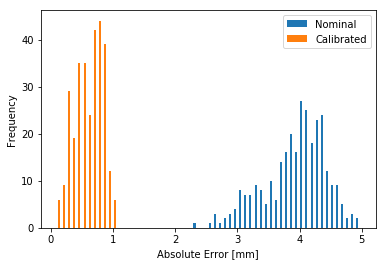

In [16]:
plt.hist(
    x=[nominal_errors,
       calibrated_errors],
    label=['Nominal', 'Calibrated'],
    bins=60,
);
plt.xlabel('Absolute Error [mm]');
plt.ylabel('Frequency');
plt.legend();

# Discussion
- A portion of the measured configurations and positions should be set aside for validation after calibration (i.e., optimization)
    - This is to check the optimized model for overfitting
- A calibrated robot model is never perfect in real life
    - The goal is often to reduce the max error under a desired threshold
- Small errors in the robot model can generate large errors in Cartesian position